In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

import random
import math
import networkx as nx

import boto3
from PIL import Image

import requests
import json

%matplotlib inline

plt.style.use('ggplot')

pd.set_option('display.max_columns', 50)

In [ ]:
# # Visualize the images and their annotations
# image_identifiers = list(image_paths.keys())
# random.shuffle(image_identifiers) 
# for image_id in image_identifiers:
#     image_path = image_paths[image_id]
#     image = plt.imread(image_path)
#     bbox = image_bboxes[image_id]
#     parts = image_parts[image_id]
#     class_label = image_class_labels[image_id]
#     class_name = class_names[class_label]
      
#     # Render the image
#     plt.close(1)
#     fig = plt.figure(1, figsize=(16, 12))
#     plt.imshow(image)
#     plt.title("Image ID: %s \n Class Label: %s  [ID: %s]" % (image_id, class_name, class_label))
      
#     # Render the bounding box annotations
#     bbox_x, bbox_y, bbox_width, bbox_height = bbox
#     currentAxis = plt.gca()
#     currentAxis.add_patch(plt.Rectangle((bbox_x , bbox_y), bbox_width, bbox_height, facecolor="green", alpha=0.3))
      
#     # Render the part annotations
#     if has_networkx:
#     # Use networkx spring layout
        
#         G = nx.Graph()
#         part_data = []
#         initial_positions = {}
#         for part_id, part in enumerate(parts):
#             x, y, v = part
#             if v:
#                 part_str = 'part_%d' % (part_id,)
#                 label_str = 'label_%d' % (part_id,)
            
#                 G.add_node(part_str)
#                 G.add_node(label_str)
#                 G.add_edge(part_str, label_str)
            
#                 part_data.append(part_str)
            
#                 initial_positions[part_str] = (x, y)
#                 initial_positions[label_str] = (x, y)
            
#             positions = nx.spring_layout(G, dim=2, k=20.0, pos=initial_positions, fixed=part_data)
        
#             for part_id, part in enumerate(parts):
#                 x, y, v = part
#                 if v:
#                     plt.plot(x, y, 'o')
            
#                     label_str = 'label_%d' % (part_id,)
#                     label_position = positions[label_str]
#                     label_xy = (label_position[0] * bbox_width + bbox_x, label_position[1] * bbox_height + bbox_y)
#                     plt.annotate(
#                       part_names[part_id], 
#                       xy=(x, y),
#                       xycoords='data', 
#                       xytext= label_xy, 
#                       textcoords='data',
#                       ha='right', 
#                       va='bottom',
#                       bbox=dict(boxstyle= 'round,pad=0.5', 
#                             fc='yellow', 
#                             alpha=0.5),
#                       arrowprops=dict(arrowstyle='->', 
#                               connectionstyle='arc3,rad=0')
#                     )
    
#                 else:
#                     # just a basic label annotation for the part locations
#                     offset = (2 * math.pi) / len(parts)
#                     for part_id, part in enumerate(parts):
#                         x, y, v = part
#                         if v: 
#                             # try to offset the part labels so that they don't overlap too badly
#                             dist = random.randint(35, 65)
#                             offset_x = dist * math.cos(offset * part_id)
#                             offset_y = dist * math.sin(offset * part_id)
          
#                             plt.plot(x, y, 'o')
#                             plt.annotate(
#                               part_names[part_id], 
#                               xy=(x, y), 
#                               xytext=(offset_x, offset_y), 
#                               textcoords='offset points', 
#                               ha='right', 
#                               va='bottom',
#                               bbox=dict(boxstyle= 'round,pad=0.5', 
#                                 fc='yellow', 
#                                 alpha=0.5),
#                               arrowprops=dict(arrowstyle='->', 
#                                   connectionstyle='arc3,rad=0')
#                             )
  
#     plt.show(block=False)

In [3]:
# def rename_multiple_files(path,obj):

#     i=0

#     for filename in os.listdir(path):
#         try:
#             f,extension = os.path.splitext(path+filename)
#             src=path+'/'+filename
#             dst=path+'/'+obj+str(i)+extension
#             os.rename(src,dst)
#             i+=1
#             print('Rename successful.')
#         except:
#             i+=1

# path='training_set'
# obj=f"{src_path.split('.')[1]}"
# rename_multiple_files(path,obj)

In [2]:
# keras and tensorflow downloads
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D # CNN
from tensorflow.keras.callbacks import TensorBoard # graphical visual of loss and accuracy over the epochs of train and test set

import pickle # save images
import time # get time stamp of models trained

In [36]:
bucket = 'cwbirdsimages'
dir_path = 'images'
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key=f'{dir_path}/0295/01f53d6bf5e449438d2bb79e0854bca4.jpg')

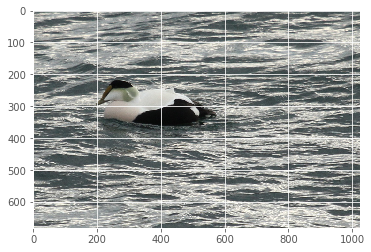

In [37]:
import matplotlib.image as mpimg
from io import BytesIO

file_stream = BytesIO(obj['Body'].read())
im = mpimg.imread(file_stream, 'jpg')

plt.figure(0)
plt.imshow(im)

In [ ]:
# loan_data = []
#     for filename in csv_files:
#         s3 = boto3.client('s3')
#         obj = s3.get_object(Bucket=bucket, Key=filename)
#         data = obj['Body'].read()
#         f = BytesIO(data)
#         data = pd.read_csv(f, header=1, low_memory=False, na_values='n/a',
#                            usecols=columns, nrows=number_of_rows) 
#         loan_data.append(data)
#     loans = pd.concat(loan_data)
#     # Loan IDs are unique and we can access specific loans much faster by setting them as the index.
#     #loans.set_index('id', inplace=True)
#     return loans

In [1]:
from PIL import Image

def resize_multiple_images(src_folder, dst_path):
    # src_folder is the location where images are saved
    for dirpath, dirnames, filenames in os.walk(src_folder):
        for filename in os.listdir(dirpath):
            try:
                img=Image.open(filename+'.jpg')
                new_img = img.resize((64,64))
                if not os.path.exists(dst_path):
                    os.makedirs(dst_path)
                new_img.save(dst_path+'/'+filename)
                print('Resized and saved {}.'.format(filename))
            except:
                continue

# src_folder = 'images'
# dst_path = 'resized_images'
# resize_multiple_images(src_folder, dst_path)

In [4]:
from PIL import Image
import os
import numpy as np
import re

def get_data(path):
    all_images_as_array=[]
    label=[]
    for filename in os.listdir(path):
        try:
            if re.match(r'Black_footed_Albatross',filename):
                label.append(1)
            else:
                label.append(0)
            img=Image.open(path + '/'+ filename)
            np_array = np.asarray(img)
            l,b,c = np_array.shape
            np_array = np_array.reshape(l*b*c,)
            all_images_as_array.append(np_array)
        except:
            continue

    return np.array(all_images_as_array), np.array(label)

# path_to_train_set = 'train_set/'
# path_to_test_set = 'test_set/'
# X_train,y_train = get_data(path_to_train_set)
# X_test, y_test = get_data(path_to_test_set)

# print('X_train set : ',X_train)
# print('y_train set : ',y_train)
# print('X_test set : ',X_test)
# print('y_test set : ',y_test)

In [5]:
# def load_bounding_box_annotations(dataset_path=''):
#     bboxes = {}
#     with open(os.path.join(dataset_path, 'bounding_boxes.txt')) as f:
#         for line in f:
#             pieces = line.strip().split()
#             image_id = pieces[0]
#             bbox = map(int, pieces[1:])
#             bboxes[image_id] = bbox
#     return bboxes

# def load_part_annotations(dataset_path=''):
#     parts = {}
#     with open(os.path.join(dataset_path, 'parts/part_locs.txt')) as f:
#         for line in f:
#             pieces = line.strip().split()
#             image_id = pieces[0]
#             parts.setdefault(image_id, [0] * 11)
#             part_id = int(pieces[1])
#             parts[image_id][part_id] = [int(x) for x in pieces[2:]]
#     return parts  
  
# def load_part_names(dataset_path=''):
#     names = {}
#     with open(os.path.join(dataset_path, 'parts/parts.txt')) as f:
#         for line in f:
#             pieces = line.strip().split()
#             part_id = int(pieces[0])
#             names[part_id] = ' '.join(pieces[1:])
#     return names  

In [5]:
def load_class_names(dataset_path=''):
    names = {}
    with open(os.path.join(dataset_path, 'classes.txt')) as f:
        for line in f:
            pieces = line.strip().split()
            class_id = pieces[0]
            names[class_id] = ' '.join(pieces[1:])
    return names

In [5]:
def load_image_labels(dataset_path=''):
    labels = {}
    with open(os.path.join(dataset_path, 'image_class_labels.txt')) as f:
        for line in f:
            pieces = line.strip().split()
            image_id = pieces[0]
            class_id = pieces[1]
            labels[image_id] = class_id
    return labels

In [5]:
        
def load_image_paths(dataset_path='', path_prefix=''):
    paths = {}
    with open(os.path.join(dataset_path, 'images.txt')) as f:
        for line in f:
            pieces = line.strip().split()
            image_id = pieces[0]
            path = os.path.join(path_prefix, pieces[1])
            paths[image_id] = path
    return paths

In [5]:
def load_image_sizes(dataset_path=''):
    sizes = {}
    with open(os.path.join(dataset_path, 'sizes.txt')) as f:
        for line in f:
            pieces = line.strip().split()
            image_id = pieces[0]
            width, height = map(int, pieces[1:])
            sizes[image_id] = [width, height]
    return sizes

In [5]:
def load_hierarchy(dataset_path=''):
    parents = {}
    with open(os.path.join(dataset_path, 'hierarchy.txt')) as f:
        for line in f:
            pieces = line.strip().split()
            child_id, parent_id = pieces
            parents[child_id] = parent_id
    return parents

In [5]:
def load_train_test_split(dataset_path=''):
    train_images = []
    test_images = []
    with open(os.path.join(dataset_path, 'train_test_split.txt')) as f:
        for line in f:
            pieces = line.strip().split()
            image_id = pieces[0]
            is_train = int(pieces[1])
            if is_train:
                train_images.append(image_id)
            else:
                test_images.append(image_id)
    return train_images, test_images

In [5]:
# def load_photographers(dataset_path=''):
#     photographers = {}
#     with open(os.path.join(dataset_path, 'photographers.txt')) as f:
#         for line in f:
#             pieces = line.strip().split()
#             image_id = pieces[0]
#             photographers[image_id] = ' '.join(pieces[1:])
#     return photographers

In [6]:
dataset_path = 'nabirds/'
image_path  = 'nabirds/images'

In [7]:
image_paths = load_image_paths(dataset_path, path_prefix=image_path)
image_sizes = load_image_sizes(dataset_path)
# image_bboxes = load_bounding_box_annotations(dataset_path)
# image_parts = load_part_annotations(dataset_path)
image_class_labels = load_image_labels(dataset_path)

In [8]:
class_names = load_class_names(dataset_path)
class_hierarchy = load_hierarchy(dataset_path)

# Load in the part data
# part_names = load_part_names(dataset_path)
# part_ids = part_names.keys()
# part_ids = sorted(part_ids)

# Load in the photographers
# photographers = load_photographers(dataset_path)

# Load in the train / test split
train_images, test_images = load_train_test_split(dataset_path)

In [65]:
# image_paths['0090914b-db16-4b8f-9f95-045d8a90d09d']

birds_filenames = [x for x in image_paths.values()]

print(birds_filenames[0])
print(len(birds_filenames))

image = Image.open(birds_filenames[3000])
print(np.array(image).shape)

fig, axes = plt.subplots(1, 4, figsize=(20,10))

axes[0].imshow(image)
axes[0].set_title('original')
for ax, channel, name in zip(axes[1:], image.split(), ['red channel', 'green channel', 'blue channel']):
    ax.imshow(channel, cmap='gray')
    ax.set_title(name)